### Compute sparse inverse solution with mixed norm: MxNE and irMxNE

In [2]:
import numpy as np
import mne
from mne.datasets import sample
from mne.inverse_sparse import mixed_norm,make_stc_from_dipoles
from mne.minimum_norm import apply_inverse,make_inverse_operator
from mne.viz import plot_sparse_source_estimates,plot_dipole_locations,plot_dipole_amplitudes


In [3]:
data_path = sample.data_path()
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
ave_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
cov_fname = data_path + '/MEG/sample/sample_audvis-shrunk-cov.fif'
subjects_dir = data_path + '/subjects'

In [4]:
# Read noise covariance matrix
cov = mne.read_cov(cov_fname)
cov

    365 x 365 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 59) active


<Covariance  |  size : 365 x 365, n_samples : 38720, data : [[  2.58607874e-23   6.29495097e-24   7.04486582e-25 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  6.29495097e-24   9.22800262e-24   1.50545865e-25 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.04486582e-25   1.50545865e-25   6.49899073e-26 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.56158546e-11
    2.32258079e-11   2.02070970e-11]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.32258079e-11
    2.58780973e-11   1.72833341e-11]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.02070970e-11
    1.72833341e-11   2.46632855e-11]]>

In [5]:
# Handling average file
condition = 'Left Auditory'
evoked = mne.read_evokeds(ave_fname,condition=condition,baseline=(None,0))
evoked.crop(tmin=0,tmax=0.3)

Reading /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)


<Evoked  |  'Left Auditory' (mean, N=55), [0, 0.29969] sec, 376 ch, ~4.2 MB>

In [6]:
# Handling forward solution
forward = mne.read_forward_solution(fwd_fname)
forward

Reading forward solution from /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame


<Forward | MEG channels: 306 | EEG channels: 60 | Source space: Surface with 7498 vertices | Source orientation: Free>

In [7]:
forward['src']

<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=3732, coordinate_frame=head>, <surface (rh), n_vertices=156866, n_used=3766, coordinate_frame=head>]>

In [8]:
## Run Solver 
# regularization parameter between 0 and 100 (100 is high)
alpha = 5 
# loose orientation & depth weighting
loose,depth = 0.2,0.9
# if > 1 use L0.5/L2 reweighted mixed norm solver
# if n_mxne_iter > 1 dSPM weighting can be avoided.
n_mxne_iter = 10

In [9]:
# Compute dSPM solution to be used as weights in MxNE
inverse_operator = make_inverse_operator(evoked.info,forward,
                                        cov,depth=depth,fixed=True,
                                        use_cps=True)
stc_dspm = apply_inverse(evoked,inverse_operator,lambda2=1./9.,
                        method='dSPM')

Forward is not surface oriented, converting.
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 364 channels.
    Created an SSP operator (subspace dimension = 4)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
estimated rank (eeg): 58
Setting small EEG eigenvalues to zero.
Not doing PCA for EEG.
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.9
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    C

In [10]:
# Compute (ir)MxNE inverse solution with dipole output
dipoles,residual = mixed_norm(evoked,forward, cov, alpha, loose=loose, depth=depth, maxit=3000,
    tol=1e-4, active_set_size=10, debias=True, weights=stc_dspm,
    weights_min=8., n_mxne_iter=n_mxne_iter, return_residual=True,
    return_as_dipoles=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 364 channels.
    Created an SSP operator (subspace dimension = 4)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
estimated rank (eeg): 58
Setting small EEG eigenvalues to zero.
Not doing PCA for EEG.
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
Whitening lead field matrix.
Applying loose dipole orientations. Loose value of 0.2.
Reducing source space to 543 sources
Whitening data matrix.
-- ALPHA MAX : 100.0
Using block coordinate descent
Iteration 1 :: p_obj 1469.724483 :: dgap 886.628861 ::n_active_start 10 :: n_active_end 7
Iteration 2 :: p_obj 1379.767877 :: 

In [11]:
# Plot dipole activations
plot_dipole_amplitudes(dipoles);

In [12]:
print(dipoles[0])
# dipoles[0].pos
# dip.amplitude
dir(dipoles[0])

<Dipole  |  n_times : 181, tmin : 0.000, tmax : 0.300>


['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__len__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'amplitude',
 'conf',
 'copy',
 'crop',
 'gof',
 'khi2',
 'name',
 'nfree',
 'ori',
 'plot_amplitudes',
 'plot_locations',
 'pos',
 'save',
 'times']

In [13]:
dip.amplitude.shape

NameError: name 'dip' is not defined

In [33]:
# Plot dipole location of the strongest dipole with MRI slices
idx = np.argmax([np.max(np.abs(dip.amplitude)) for dip in dipoles])

In [34]:
idx

16

/home/reallocing/GitHub/science_rcn/.eggs/numpy-1.13.3-py2.7-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/reallocing/GitHub/science_rcn/.eggs/numpy-1.13.3-py2.7-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


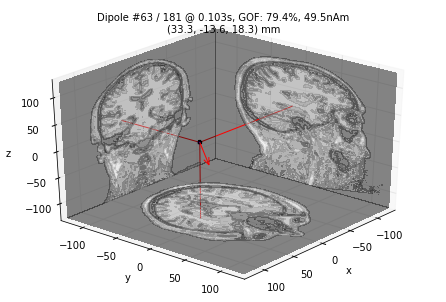

In [35]:
plot_dipole_locations(dipoles[idx], forward['mri_head_t'], 'sample',
                      subjects_dir=subjects_dir, mode='orthoview',
                      idx='amplitude');

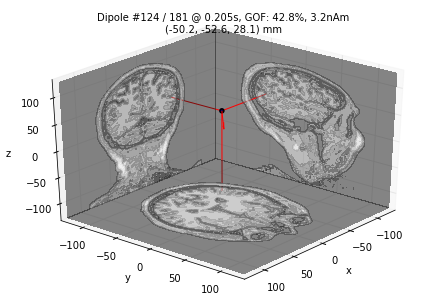

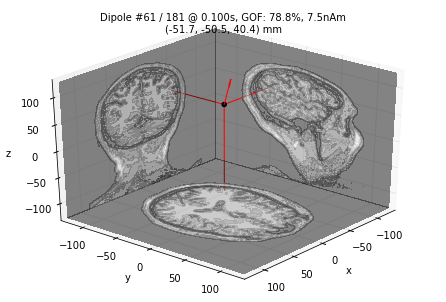

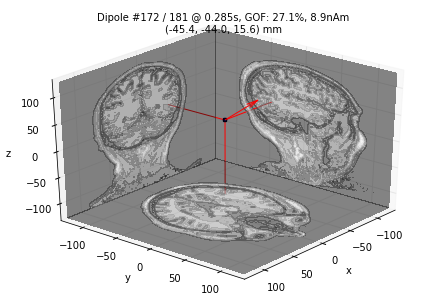

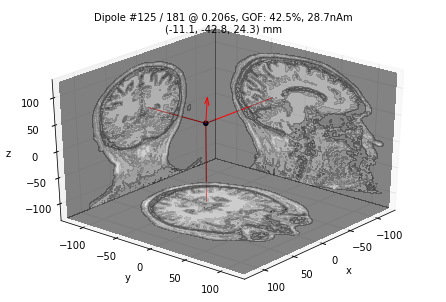

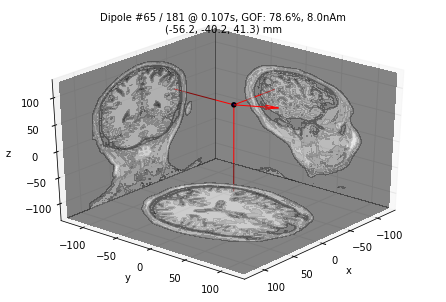

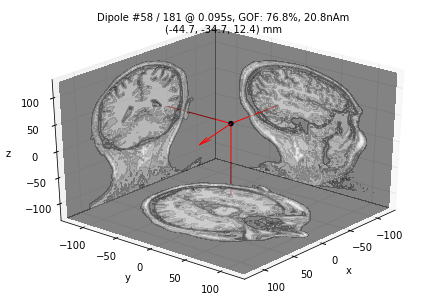

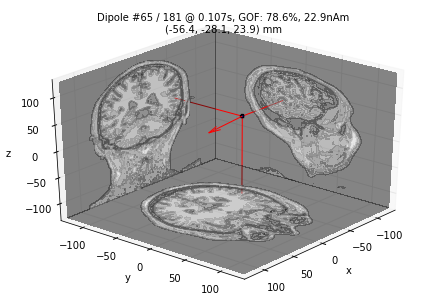

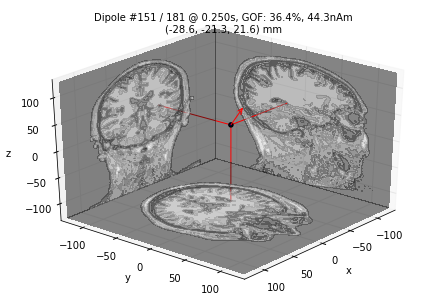

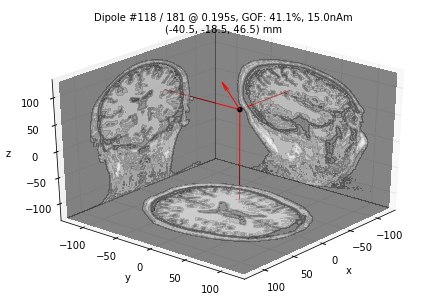

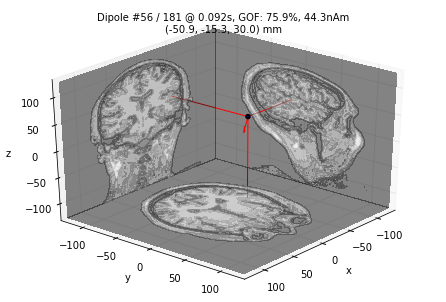

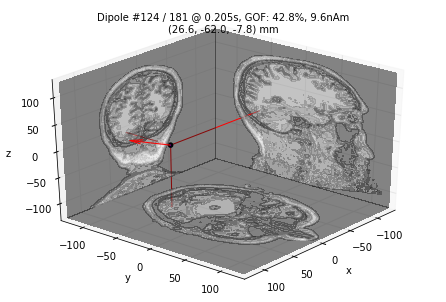

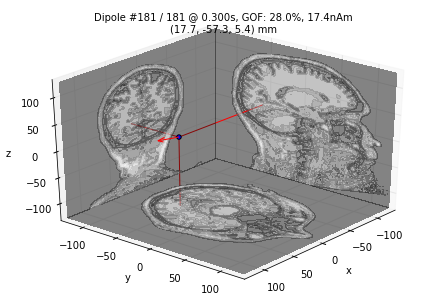

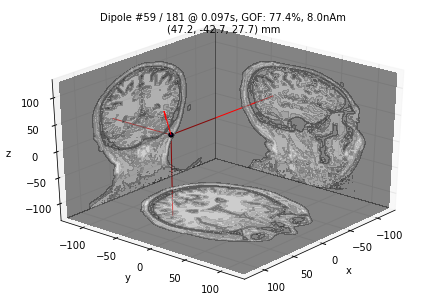

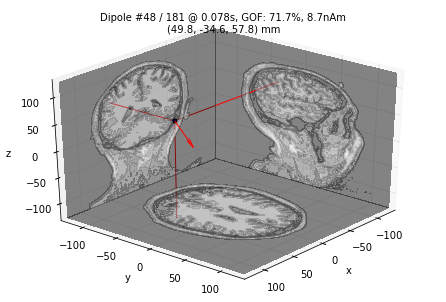

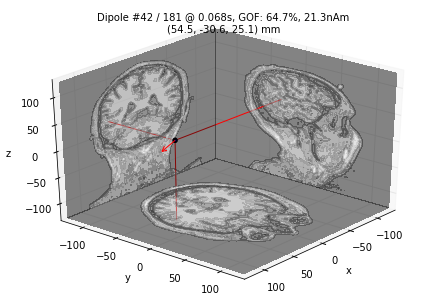

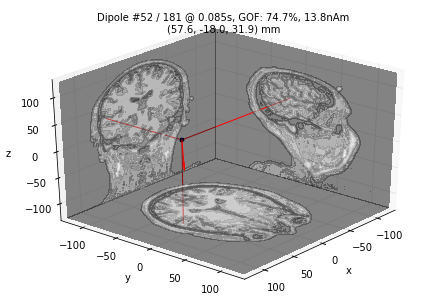

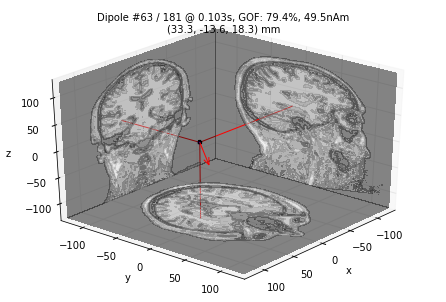

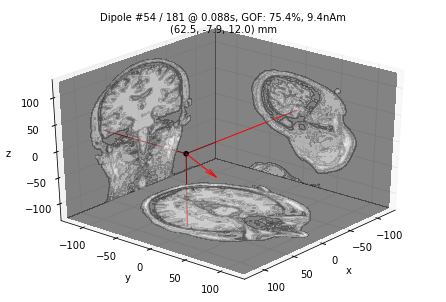

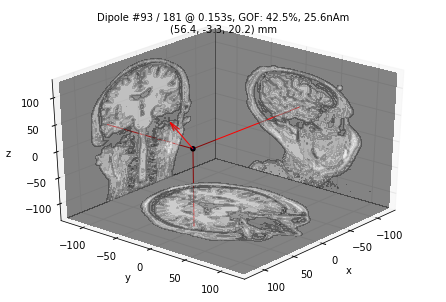

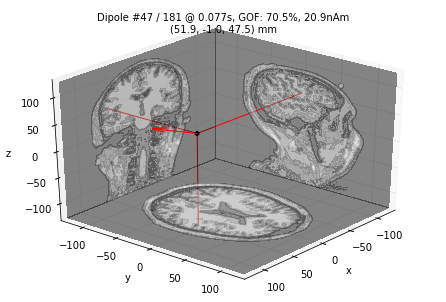

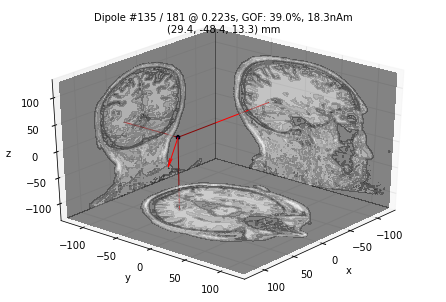

In [36]:
# Plot dipole locations of all dipoles with MRI slices
for dip in dipoles:
    plot_dipole_locations(dip,forward['mri_head_t'],
                         'sample',subjects_dir=subjects_dir,
                         mode='orthoview',idx='amplitude');

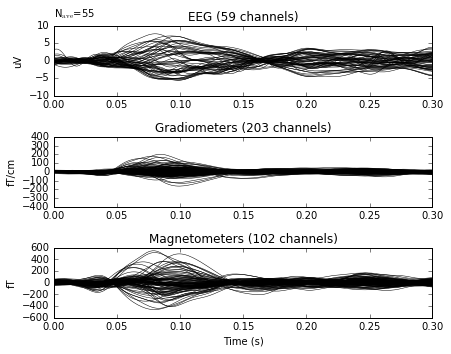

In [40]:
# Plot residual
ylim = dict(eeg=[-10, 10], grad=[-400, 400], mag=[-600, 600])
evoked.pick_types(meg=True,eeg=True,exclude='bads')
evoked.plot(ylim=ylim,proj=True,time_unit='s');

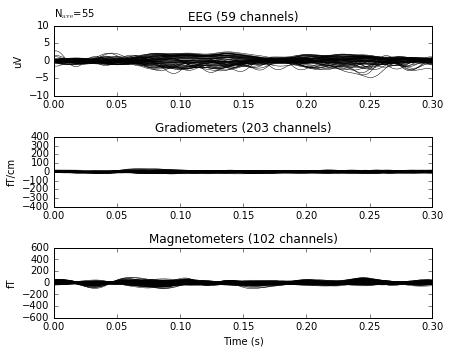

In [41]:
residual.pick_types(meg=True,eeg=True,exclude='bads')
residual.plot(ylim=ylim,proj=True,time_unit='s');

In [ ]:
## Generate stc from dipoles
stc = make_stc_from_dipoles(dipoles,forward['src'])

In [ ]:
stc.data.shape

Total number of active sources: 21


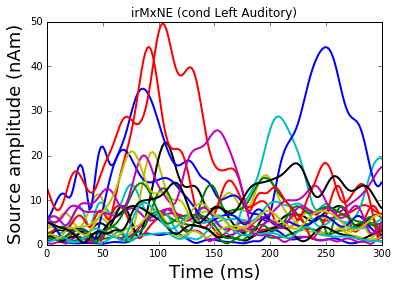

In [45]:
## View in 2D and 3D
solver = "MxNE" if n_mxne_iter == 1 else "irMxNE"
plot_sparse_source_estimates(forward['src'], stc, bgcolor=(1, 1, 1),
                             fig_name="%s (cond %s)" % (solver, condition),
                             opacity=0.1)

In [ ]:
# Morph onto fsaverage brain and view
morph = mne.compute_source_morph(stc,subject_from='sample',
                                subject_to='fsaverage',spacing=None,
                                sparse=True,subjects_dir=subjects_dir)


In [ ]:
stc_fsaverage = morph.apply(stc)
src_fsaverage_fname = subjects_dir + '/fsaverage/bem/fsaverage-ico-5-src.fif'
src_fsaverage = mne.read_source_spaces(src_fsaverage_fname)

plot_sparse_source_estimates(src_fsaverage, stc_fsaverage, bgcolor=(1, 1, 1),
                             fig_name="Morphed %s (cond %s)" % (solver,
                             condition), opacity=0.1)

### Ref
- https://mne-tools.github.io/stable/auto_examples/inverse/plot_mixed_norm_inverse.html#sphx-glr-auto-examples-inverse-plot-mixed-norm-inverse-py